# EM538: Homework 1: kNN Regressor
See: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

EM 538: Practical Machine Learning for Engineering Analytics (Spring 2025)  

- Instructor: Fred Livingston (fjliving@ncsu.edu)   
- Student: Mike Keating

## California Housing Prices Dataset

### Task 1: Load Housing Dataset [ 16 pts ]

In [16]:

import pandas as pd
df_housing = pd.read_csv('housing.csv', usecols = ['longitude', 'latitude', 'median_house_value'])

We can answer all of part one by using the info() method on our dataframe:

In [17]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   median_house_value  20640 non-null  float64
dtypes: float64(3)
memory usage: 483.9 KB



* 1a. How many features (m) are in the dataset [ 4 pts ]
  * There are 3 features
* 1b. Describe the features names [ 4 pts ]
  * The feature names are longitude, latitude, and median_house_value.
* 1c. How many samples (n) are in this dataset [ 4 pts ]
  * n = 20640
* 1d. Describe the classification outputs (datatypes, etc) y [ 4 pts ]
  * All datatypes are float64.


### Task 2: Visualize Housing Data [ 15 pts ]

* 2a. Using the California Data set, plot the median house value, w.r.t to the following features: longitude, latatitude [ 13 pts ]


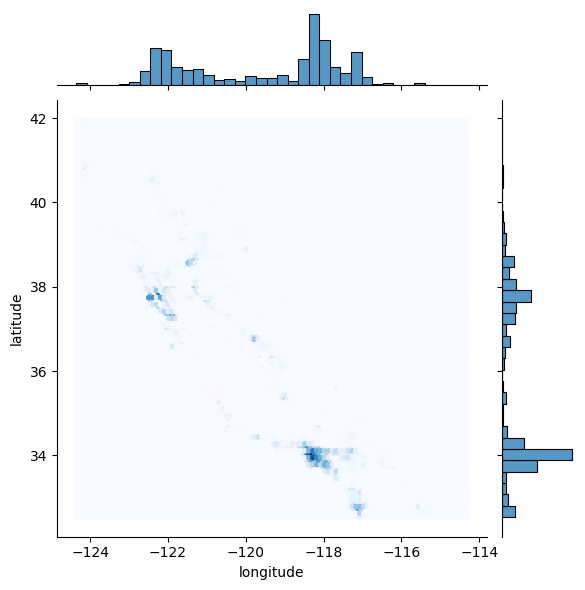

In [23]:
import seaborn as sns
g = sns.jointplot(x='longitude', y='latitude', data=df_housing, kind='hex', gridsize=100, cmap='Blues')



* 2b. Where are the most expensize house located [ 2 pts ]

From the above image (you can see the shape of California), the most expensive homes are located in the Bay Area, Los Angeles area, and San Diego (farthest south)

### Task 3: Prepare Training, Testing Datasets [ 14 pts ]
Using the Simple Holdout Method with a random seed of 123, Randoms sample 20% of the Data for Testing, and the remainder for Training



* 3a. Implement the Simple Holdout Method Algorith in the bellow cell [ 8 pts ]

In [27]:
# Prepare Training, and Testing Datasets
from sklearn.model_selection import train_test_split

# Longitude and latitude are our features/predictors.
X = df_housing[['longitude', 'latitude']]
y = df_housing[['median_house_value']]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=123, 
                                                    shuffle=True)

* 3b. Determine the size of the Training Set [ 3 pts ]
* 3c. Determine the size of the Testing Set [ 3 pts ]

In [1]:
import numpy as np
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')


NameError: name 'X_train' is not defined

### Task 4: - Fit k-Nearest Neighbor Model [ 45 pts ]

Next, we are going to use the `KNeighborsRegressor` class from scikit-learn and instantiate a new KNN object, which we call `knn_model`. Then, we "fit" this model the training dataset.

Training our model on all possible K values (odd) from 3 to 10:

Chose an odd value of K when you have 2 classes to avoid ties. i.e. If the new data point is right between the two classes it cannot decide which one to go with.
K must not be a multiple of the number of classes
If K is very small ( Overfit ), will not be accurate if you have many data points (n)
If K is very large ( Underfit ), K must not be equal to the number of data points n

* 4a. Implement the KNeighborsRegressor for k = 3, 5, 7, and 10 [ 35 pts ]

In [ ]:

# Train a KNeighbors Regression model
from sklearn.neighbors import KNeighborsRegressor
k_values = [3, 5, 7, 10]
models_dict = {}

for k_value in k_values:
    model_dict = {}
    knn_model = KNeighborsRegressor(n_neighbors=k_value)
    print(f"Building k-nearest neighbors model: \n{knn_model}")
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    print('Coeff of Determination: %.4f' % (knn_model.score(X_test, y_test)))
    print('-'*40)

    # Calculate the max error.
    max_error = (np.abs(y_pred - y_test)).max()
    model_dict['n_neighbors'] = k_value
    model_dict['max_error'] = float(max_error.iloc[0])

    models_dict[k_value] = model_dict

# Return the model with the lowest max error
for key, value in models_dict.items():
    

Building k-nearest neighbors model: 
KNeighborsRegressor(n_neighbors=3)
Coeff of Determination: 0.7796
----------------------------------------
Building k-nearest neighbors model: 
KNeighborsRegressor()
Coeff of Determination: 0.7906
----------------------------------------
Building k-nearest neighbors model: 
KNeighborsRegressor(n_neighbors=7)
Coeff of Determination: 0.7935
----------------------------------------
Building k-nearest neighbors model: 
KNeighborsRegressor(n_neighbors=10)
Coeff of Determination: 0.7970
----------------------------------------


In [ ]:

class KNNRegressorBuilder():
    def __init__(self, X_train, y_train, X_test, y_test, neighbors=[5]):
        self.neighbors = neighbors
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def build_models()

* 4b. Determine the optimal n_neighbors based on Max Error [ 5 pts ]
* 4c. What is the maximum error of the prediction [ 5 pts ]

### Task 5: Evaluate the Accuracy of the best performing model and determine is Max Error [ 10 pts ]

* 5a. Using the Test Data set, determine the accuracy of the final model [ 5 pts ]
* 5b. Show Price prediction using the test data set [ 5 pts ]